In [50]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random

In [51]:
DATA_DIR = '/Users/carki/Desktop/Dev/codeit/common/data'

In [52]:
# device 설정 (GPU가 있으면 GPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("사용하는 device:", device)

사용하는 device: cpu


In [53]:
# MNIST 데이터셋 준비
# 데이터 전처리를 위해 ToTensor 변환을 적용
transform = transforms.Compose([transforms.ToTensor()])

# 학습용 MNIST 데이터셋 다운로드 및 로드
trainset = torchvision.datasets.MNIST(root=DATA_DIR, 
                                      train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)

In [54]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        """
        VAE 모델 초기화 함수.
        매개변수:
            latent_dim : 잠재 공간(latent space)의 차원 (기본값: 2)
        """
        super(VAE, self).__init__()
        # 인코더 정의: 입력 이미지를 400 차원의 중간 표현으로 변환
        self.fc1 = nn.Linear(28*28, 400)
        
        self.fc21 = nn.Linear(400, latent_dim) # 잠재 변수의 평균
        self.fc22 = nn.Linear(400, latent_dim) # 잠재 변수의 로그분산
        
        # 디코더 정의: 잠재 변수에서 400 차원의 중간 표현을 복원한 후 원래 이미지 크기로 복원
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28 * 28)
        
    def encode(self, x):
        """
        인코딩 함수: 입력 x를 인코더를 통해 숨은 표현(hidden representation)으로 변환하고,
        잠재 변수의 평균과 로그 분산을 출력합니다.
        """
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    # z 값이 생성되는 부분
    def reparameterize(self, mu, logvar): # 뮤, 로그분산
        # 표준편차 계산 logvar는 log(sigma^2) -->  std = exp((1/2) * log(sigma^2)) = sigma
        std = torch.exp(0.5 * logvar) 
        
        # 평균 0, 표준편차 1인 노이즈 생성
        # 입실론
        eps = torch.randn_like(std)    # 평균 0, 표준편차 1인 노이즈 생성
        
        return mu + eps * std
        
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        
        return torch.sigmoid(self.fc4(h3)) # 출력값을 0~1 사이로 제한
    
    def forward(self, x):
        """
        순전파 함수: 인코더 -> 재파라미터화 -> 디코더 순서로 진행합니다.
        반환값은 재구성된 이미지, 잠재 변수의 평균, 로그 분산입니다.
        """
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        
        return self.decode(z), mu, logvar
        

# 손실함수 Loss 정의

In [ ]:
# VAE의 손실 함수는 재구성 손실(BCE)과 KL 발산(KLD) 손실의 합으로 구성됩니다.
# beta 값은 KL 손실의 가중치를 조절합니다.
beta = 1.0

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28 * 28))
    KLD = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)
    # 시그마 제곱 logvar.exp()
    # 로그 시그마 제곱 logvar
    return BCE + beta * KLD

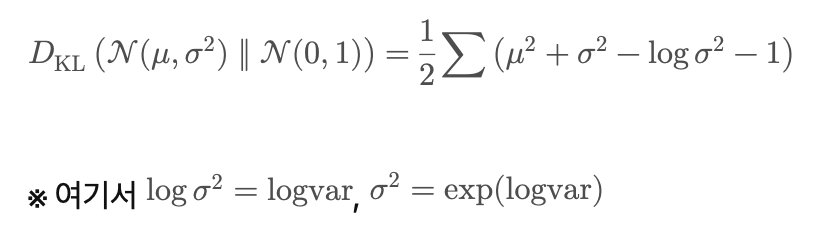

# 모델 학습
2D 잠재 공간으로 학습

In [56]:
# 잠재 공간 차원 설정 (여기서는 2차원)
latent_dim = 2
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100

# print("2D 잠재 공간으로 학습 시작...")
# for epoch in range(num_epochs):
#     model.train()  # 모델을 학습 모드로 설정
#     train_loss = 0
#     for data, _ in trainloader:
#         data = data.to(device)  # 데이터 GPU로 이동 (가능한 경우)
#         optimizer.zero_grad()   # 기울기 초기화
#         recon_batch, mu, logvar = model(data)  # 순전파 진행
#         loss = loss_function(recon_batch, data, mu, logvar)  # 손실 계산
#         loss.backward()         # 역전파
#         train_loss += loss.item()
#         optimizer.step()        # 가중치 업데이트

#     # 에포크마다 평균 손실 출력
#     print(f'Epoch {epoch + 1}, Loss: {train_loss / len(trainloader.dataset):.4f}')

In [57]:
g_path = '/Users/carki/Desktop/Dev/codeit/DeepLearning(DL)/이미지생성/VAE'
model.load_state_dict(torch.load(os.path.join(g_path, 'vae_model.pth'), map_location='cpu'))

<All keys matched successfully>

# 잠재공간 시각화

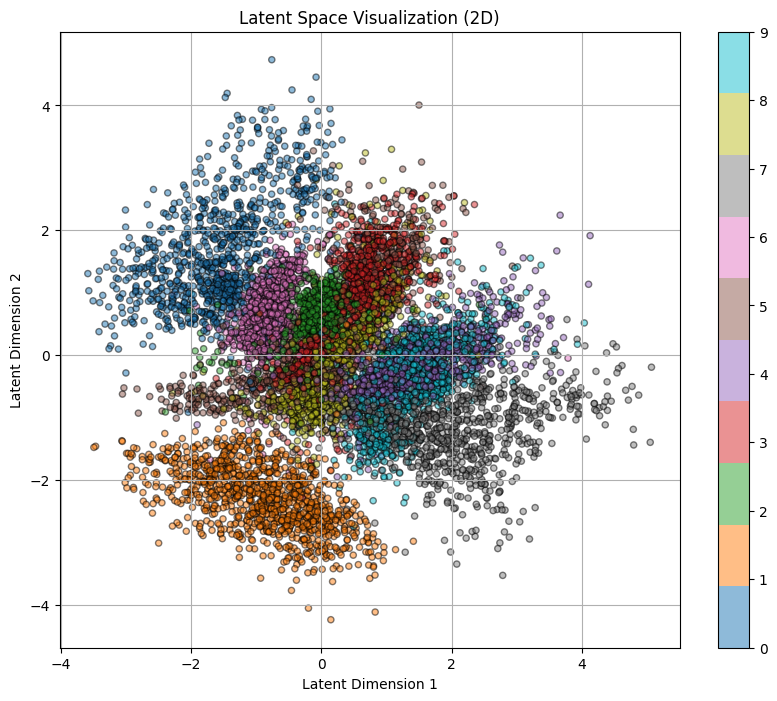

In [58]:
### 잠재 공간 시각화 (2D) 및 테스트 데이터셋 처리 ###
model.eval()  # 평가 모드로 전환
all_z = []    # 모든 잠재 변수 저장 리스트
all_labels = []  # 해당 이미지의 레이블 저장 리스트

# 테스트 데이터셋 다운로드 및 로드 (학습 데이터와는 별개)
with torch.no_grad():
    testset = torchvision.datasets.MNIST(root=DATA_DIR, 
                                         train=False, 
                                         download=True, 
                                         transform=transform)
    
    testloader = DataLoader(testset, batch_size=64, shuffle=False)
    
    # 테스트 데이터셋에 대해 인코딩 및 잠재 변수 샘플링 진행
    for data, labels in testloader:
        data = data.to(device)
        mu, logvar = model.encode(data.view(-1, 28 * 28))
        z = model.reparameterize(mu, logvar)
        z = z.cpu().numpy()

        all_z.append(z)
        all_labels.append(labels)
        
    all_z = np.concatenate(all_z)
    all_labels = np.concatenate(all_labels)
    
    # 2D 잠재 공간에 대해 산점도(scatter plot) 시각화
    plt.figure(figsize=(10, 8))
    
    scatter = plt.scatter(all_z[:, 0], 
                          all_z[:, 1], 
                          c=all_labels, 
                          cmap='tab10', 
                          alpha=0.5, 
                          edgecolors='k', 
                          s=20)
    
    plt.colorbar(scatter, ticks=range(10))
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization (2D)')
    plt.grid(True)
    plt.show()

# 잠재 공간을 활용한 새로운 데이터 생성
연속적 값 조정

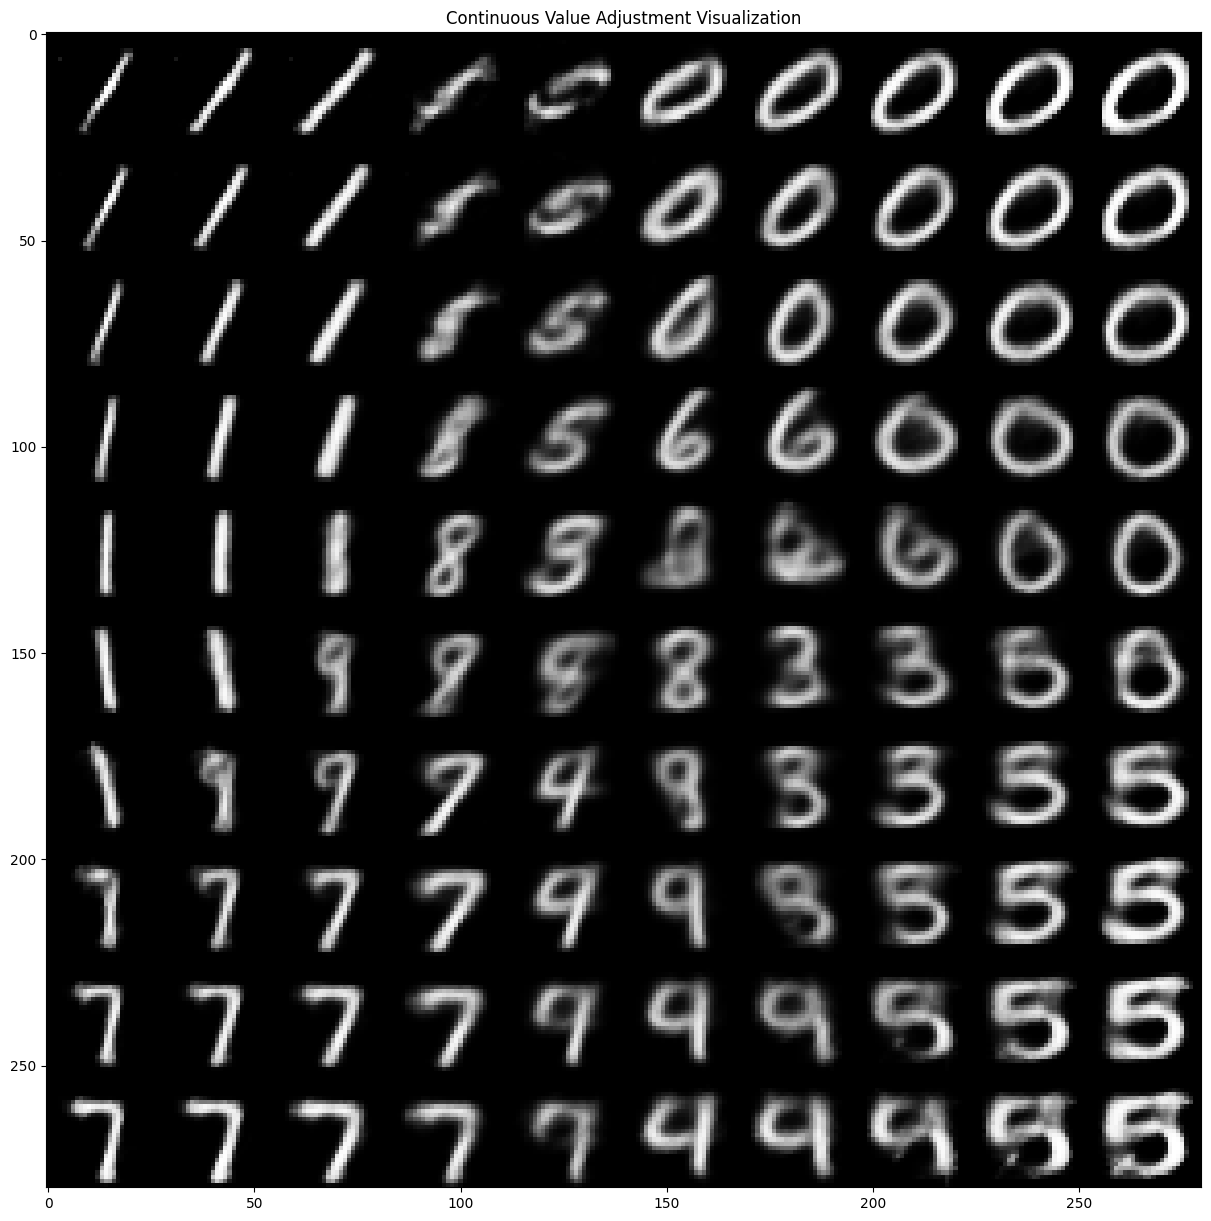

In [63]:
### 잠재 공간을 활용한 새로운 데이터 생성 (연속적 값 조정)
# 잠재 공간에서 샘플을 생성하여 디코더로 복원한 후, 그 결과를 그리드 형태로 시각화합니다.
with torch.no_grad():
    grid_x = np.linspace(-3, 3, 10)  # x축 범위 및 샘플링 개수 설정
    grid_y = np.linspace(-3, 3, 10)  # y축 범위 및 샘플링 개수 설정
    
    figure = np.zeros((28 * 10, 28 * 10))  # 전체 이미지를 저장할 빈 배열 생성
    for i, xi in enumerate(grid_x):
        for j, yi in enumerate(grid_y):
            # 현재 좌표 (xi, yi)를 잠재 변수로 변환 후 디코딩
            z_sample = torch.Tensor([[xi, yi]]).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded.view(28, 28).cpu().numpy()
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

    plt.figure(figsize=(15, 15))
    plt.imshow(figure, cmap='gray')
    plt.title('Continuous Value Adjustment Visualization')
    plt.show()


# 잠재 공간 차원 확장: 128D로 재학습

In [60]:
# 잠재 공간의 차원을 128로 확장하여 학습하면 재구성 품질이 개선될 수 있습니다.
latent_dim = 128
model128 = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100

# print("128D 잠재 공간으로 학습 시작...")
# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     for data, _ in trainloader:
#         data = data.to(device)
#         optimizer.zero_grad()
#         recon_batch, mu, logvar = model(data)
#         loss = loss_function(recon_batch, data, mu, logvar)
#         loss.backward()
#         train_loss += loss.item()
#         optimizer.step()
#     print(f'Epoch {epoch + 1}, Loss: {train_loss / len(trainloader.dataset)}')


In [61]:
g_path = '/Users/carki/Desktop/Dev/codeit/DeepLearning(DL)/이미지생성/VAE'
model128.load_state_dict(torch.load(os.path.join(g_path, 'vae_model_128.pth'), map_location='cpu'))

<All keys matched successfully>

# 128D 잠재 공간 재구성 결과 시각화

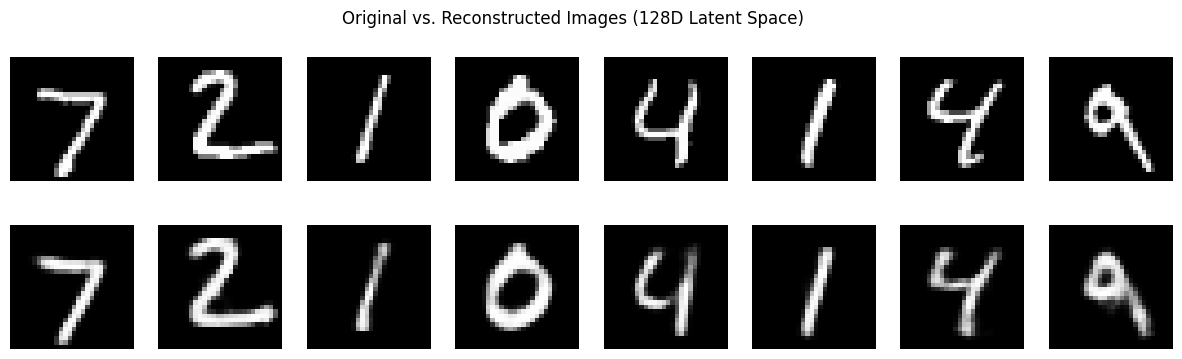

In [62]:
model128.eval()
with torch.no_grad():
    # 테스트 데이터셋에서 일부 데이터를 선택하여 재구성 결과 확인
    data, _ = next(iter(testloader))
    data = data.to(device)
    recon, _, _ = model128(data)
    recon = recon.view(-1, 1, 28, 28).cpu().numpy()

    # 원본 이미지와 재구성 이미지를 나란히 비교하여 시각화
    fig, axes = plt.subplots(2, 8, figsize=(15, 4))
    for i in range(8):
        # 첫 번째 행: 원본 이미지
        axes[0, i].imshow(data[i].cpu().numpy().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        # 두 번째 행: 재구성된 이미지
        axes[1, i].imshow(recon[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle("Original vs. Reconstructed Images (128D Latent Space)")
    plt.show()
